# xAPI-SG Processor

### Processor of traces following the Experience API for Serious Games Profile (xAPI-SG)

**xAPI-SG main reference:**  
*Applying standards to systematize learning analytics in serious games.
Ángel Serrano-Laguna, Iván Martínez-Ortiz, Jason Haag, Damon Regan, Andy Johnson, Baltasar Fernández-Manjón 
Computer Standards & Interfaces 50 (2017) 116–123, http://dx.doi.org/10.1016/j.csi.2016.09.014*

Further info on GitHub wiki page: https://github.com/e-ucm/rage-analytics/wiki/xAPI-SG-Profile 

xAPI-SG:  
- **Verbs**: "accessed", "completed", "initialized", "interacted", "pressed", "progressed", "released", "selected",          "skipped", "unlocked", "used"
- **Activity types**: "area", "controller", "cutscene", "dialog-tree", "enemy", "item", "keyboard", "level", "menu", "mouse", "non-player-character", "quest", "question", "screen", "serious-game", "touchscreen", "zone"
- **Extensions**: "health", "position", "progress"

In [2]:
import json
import numpy as np
from datetime import datetime
import copy
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from collections import Counter

In [112]:
# process each xAPI-SG trace and update player info dict
def process_xapi_trace(data, players_info):
    # available keys in dictionary
    keys = data.keys()

    ## extracting fields from xAPI trace
    # actor field
    if "actor" in keys:
        if "name" in data["actor"].keys():
            actor_name = data["actor"]["name"]
            
            if actor_name not in players_info.keys():
                players_info[actor_name] = copy.deepcopy(template_player_info)
                
            player_info = players_info[actor_name]    

    # verb field
    if "verb" in keys:
        if "id" in data["verb"].keys():
            verb_id = data["verb"]["id"]
            # process verb field
            verb_xapi = np.array(verb_id.split("/"))[-1]

    # object field
    if "object" in keys:
        if "id" in data["object"].keys():
            object_id = data["object"]["id"]
            # process object id field
            object_id_name = np.array(object_id.split("/"))[-1]
        if "definition" in data["object"].keys() and "type" in data["object"]["definition"].keys():
            object_type = data["object"]["definition"]["type"]
            # process object type field
            object_type_xapi = np.array(object_type.split("/"))[-1]

    # result field
    if "result" in keys:
        if "extensions" in data["result"].keys():
            res = data["result"]["extensions"]
        else:
            res = data["result"]
        if "success" in res.keys():
            result_success = res["success"]
        if "response" in res.keys():
            result_response = res["response"]
        if "progress" in res.keys():
            result_progress = res["progress"]
        elif "https://w3id.org/xapi/seriousgames/extensions/progress" in res.keys():
            result_progress = res["https://w3id.org/xapi/seriousgames/extensions/progress"]
        if "score" in res.keys():
            result_score = res["score"]

    # timestamp field
    if "timestamp" in keys:
        timestamp = data["timestamp"]
    
    ## update values
    try:
        # initialized traces
        if verb_xapi=="initialized":
            if object_type_xapi=="serious-game":
                player_info["game_started"] = True
            if timestamp:
                player_info["completables_times"][object_id_name] = timestamp
        # completed traces  
        elif verb_xapi=="completed":
            if object_type_xapi=="serious-game":
                player_info["game_completed"] = True
            if timestamp and object_id_name in player_info["completables_times"].keys():
                player_info["completables_times"][object_id_name] = (player_info["completables_times"][object_id_name], timestamp)
            if object_id_name and timestamp and result_score:
                player_info["completables_scores"][object_id_name]=result_score
        # progressed traces
        elif verb_xapi=="progressed":
            if object_type_xapi=="serious-game" and timestamp and result_progress:
                for timeformat in ('%Y-%m-%dT%H:%M:%SZ', '%Y-%m-%dT%H:%M:%S.%fZ'):
                    try:
                        t = datetime.strptime(timestamp, timeformat)
                    except ValueError:
                        pass
                player_info["game_progress_per_time"].append([result_progress, t])
            if verb_xapi=="progressed" and object_id_name and timestamp and result_progress:
                player_info["completables_progress"][object_id_name]=result_progress
        # selected traces
        elif verb_xapi=="selected":
            if object_id_name and result_response and result_success:
                if object_id_name in player_info["alternatives"].keys():
                    player_info["alternatives"][object_id_name].append((result_response, result_success))
                else:
                    player_info["alternatives"][object_id_name] = [(result_response, result_success)]
        # accessed traces
        if verb_xapi=="accessed":
            if object_type_xapi=="Cutscene" and object_id_name:
                player_info["videos_seen"].append(object_id_name)
        # skipped traces
        if verb_xapi=="skipped":
            if object_type_xapi=="Cutscene" and object_id_name:
                player_info["videos_skipped"].append(object_id_name)
    except NameError:
        pass  
    
# file with xAPI-SG traces      
location="" # file location
file_name="" # file name

# template with default information for each player
template_player_info = {
    "game_started": False, "game_completed": False,
    "game_progress_per_time": [], # list of pairs (game progress, timestamp)
    "completables_scores": {}, # dict completable : last score
    "completables_progress": {}, # list of pairs completable : last progress
    "completables_times": {}, # dict completable: (start, end)
    "alternatives": {}, # dict alternative: list of pairs (response, correct (T/F))
    "videos_seen": [], # list of videos seen (accessed) by player
    "videos_skipped": [] # list of videos skipped by player
}

players_info = {} # dict with players info
start_time = datetime.now() 

## FILE MUST CONTAIN LIST OF XAPI-SG PROFILE TRACES
## (traces separated by commas and enclosed by []) 
with open(location+file_name, 'r') as f:
    traces_dict = json.load(f)
    for t in traces_dict:
        process_xapi_trace(t, players_info)
    
end_time = datetime.now()

### Summary of processing

In [113]:
print("Number of xAPI-SG traces processed:", len(traces_dict))
print("Total processing time:", end_time-start_time)

Number of xAPI-SG traces processed: 84
Total processing time: 0:00:00.002328


In [115]:
# players_info

# Default analysis and visualizations

*References:* 
* **Default visualizations teacher**: https://github.com/e-ucm/rage-analytics/wiki/Default-visualizations-teacher

### Number of unique users

In [64]:
bold = '\033[1m'
print(bold,len(players_info),"users")

 5 users


In [65]:
print("Name of users:", list(players_info.keys()))

Name of users: ['Juan Gomez', 'John Smith', 'James Dean', 'Mary Kate', 'Sarah Connor']


### Filter information of player

If you want to filter the information of only one player:
- Get the name of the player from the list above
- Put that name into the **""** in the **name_player** field below
- **Un-comment two lines below**

In [111]:
# name_player = ""
# players_info = {name_player : players_info[name_player]}

## Games started / completed

In [116]:
# count of games started and completed
games_started = 0
games_completed = 0

for key in players_info.keys():
    if players_info[key]["game_started"]:
        games_started += 1
    if players_info[key]["game_completed"]:
        games_completed +=1

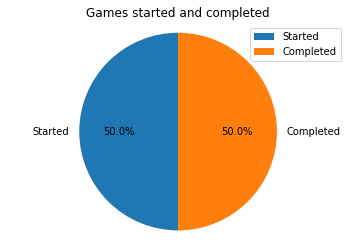

In [117]:
# pie chart of games started vs completed
labels = 'Started', 'Completed'
sizes = [games_started, games_completed]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.legend()
plt.title("Games started and completed")
plt.show()

## Videos seen / skipped by players

In [118]:
videos_seen = {}
videos_skipped = {}

for player in players_info.keys():
    # videos seen
    for video_seen in players_info[player]["videos_seen"]:
        if video_seen in videos_seen.keys():
            videos_seen[video_seen] += 1
        else:
            videos_seen[video_seen] = 1
        if video_seen not in videos_skipped.keys():
            videos_skipped[video_seen] = 0
    # videos skipped
    for video_skipped in players_info[player]["videos_skipped"]:
        if video_skipped in videos_skipped.keys():
            videos_skipped[video_skipped] += 1
        else:
            videos_skipped[video_skipped] = 1
        if video_skipped not in videos_seen.keys():
            videos_seen[video_skipped] = 0

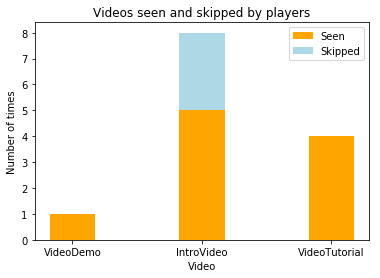

In [119]:
# Bar chart showing for each video
# the total number of times it has been seen and skipped

N = len(videos_seen)
ind = np.arange(N)

width = 0.35

p1 = plt.bar(ind, videos_seen.values(), width, color='orange')
p2 = plt.bar(ind, videos_skipped.values(), width, color='lightblue', bottom=list(videos_seen.values()))
plt.xlabel("Video")
plt.ylabel("Number of times")
plt.xticks(ind, videos_seen.keys())
plt.legend((p1[0] , p2[0]), ('Seen', 'Skipped'))
plt.title("Videos seen and skipped by players")
plt.show()

## Progress of players

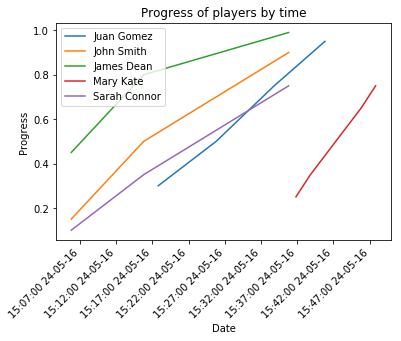

In [120]:
# line chart of progress of players by time

for player in players_info.keys():
    if players_info[player]["game_progress_per_time"] != []:
        progress_time = list(zip(*players_info[player]["game_progress_per_time"]))
        y = progress_time[0]
        x = progress_time[1]
        plt.plot(x,y, label=player)

plt.ylabel('Progress')
plt.xlabel('Date')
plt.xticks(rotation=45, ha="right")
plt.legend(loc = 'best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S %d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
plt.title("Progress of players by time")
plt.show()

## Completables scores

In [121]:
# find full list of completables
completables=set()
for player in players_info.keys():
    if players_info[player]["completables_scores"] != []:
        completables = completables.union(players_info[player]["completables_scores"].keys())
completables = list(completables)

# scores of each player per completable
players_scores = []
for player in players_info.keys():
    if players_info[player]["completables_scores"] != []:
        player_scores = []
        for c in completables:
            if c in players_info[player]["completables_scores"].keys():
                height = players_info[player]["completables_scores"][c]
            else:
                height = 0
            player_scores.append(height)
        players_scores.append(player_scores)

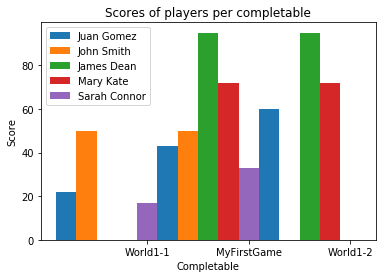

In [122]:
# bar chart showing the score achieved by players in the different completables
n_groups = len(completables)
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

for i in range(len(players_scores)):
    plt.bar(index+(i*bar_width), players_scores[i], bar_width, 
            label=list(players_info.keys())[i], 
            tick_label=completables)
    
plt.legend()
plt.xlabel("Completable")
plt.ylabel("Score")
plt.title("Scores of players per completable")
plt.show()

### Completables progress

In [123]:
# find full list of completables
completables=set()
for player in players_info.keys():
    if players_info[player]["completables_progress"] != []:
        completables = completables.union(players_info[player]["completables_progress"].keys())
completables = list(completables)

# progress of each player per completable
players_progress = []
for player in players_info.keys():
    if players_info[player]["completables_progress"] != []:
        player_progress = []
        for c in completables:
            if c in players_info[player]["completables_progress"].keys():
                height = players_info[player]["completables_progress"][c]
            else:
                height = 0
            player_progress.append(height)
        players_progress.append(player_progress)

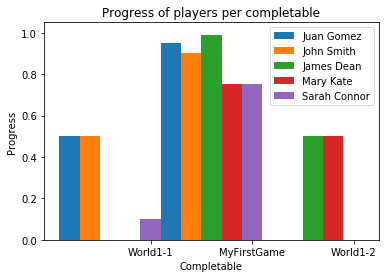

In [124]:
# Bar chart showing for each player the progress achieved in the different completables of the game as well as in the total game.
n_groups = len(completables)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

for i in range(len(players_progress)):
    plt.bar(index+i*bar_width, players_progress[i], bar_width, 
            label=list(players_info.keys())[i], 
            tick_label=completables)
    
plt.legend()
plt.xlabel("Completable")
plt.ylabel("Progress")
plt.ylim((0,1.05))
plt.title("Progress of players per completable")
plt.show()

## Completables times

In [125]:
# find full list of completables
completables=set()
for player in players_info.keys():
    if players_info[player]["completables_times"] != []:
        completables = completables.union(players_info[player]["completables_times"].keys())
completables = list(completables)

# max, min time per completable
max_times = []
min_times = []
for c in completables:
    maximum = 0
    minimum = float('Inf')
    for player in players_info.keys():
        if c in players_info[player]["completables_times"].keys():
            times = players_info[player]["completables_times"][c]
            if len(times)==2:
                end_time = datetime.strptime(times[1], '%Y-%m-%dT%H:%M:%SZ')
                start_time = datetime.strptime(times[0], '%Y-%m-%dT%H:%M:%SZ')
                raw_total_time = end_time-start_time
                total_time = raw_total_time.days*24*60+raw_total_time.seconds/60.0 # minutes
                # update values
                if total_time > maximum:
                    maximum = total_time
                if total_time < minimum:
                    minimum = total_time
    max_times.append(maximum)
    min_times.append(minimum)

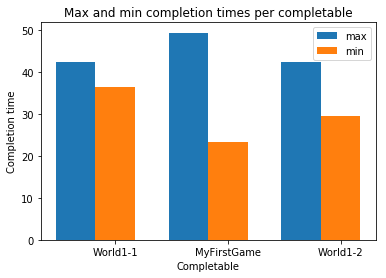

In [126]:
# Bar chart showing for each completable the maximum, minimum and mean time of completion by players.
n_groups = len(completables)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

times=[max_times,min_times]
labels=['max', 'min']

for i in range(len(labels)):
    plt.bar(index+i*bar_width, times[i], bar_width, 
            label=labels[i], 
            tick_label=completables)
    
plt.legend()
plt.xlabel("Completable")
plt.ylabel("Completion time")
plt.title("Max and min completion times per completable")
plt.show()

## Correct / incorrect alternatives per player

In [127]:
true_per_player = []
false_per_player = []

for player in players_info.keys():
    total_true = 0
    total_false = 0
    for alt in players_info[player]["alternatives"].keys():
        _, results = zip(*players_info[player]["alternatives"][alt]) # take only T/F result values
        total_true += results.count("True")
        total_false += results.count("False")
    true_per_player.append(total_true)
    false_per_player.append(total_false)

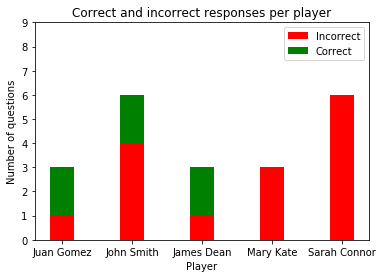

In [128]:
# Bar chart showing for each user the number of correct and incorrect alternatives 
# selected in multiple-choice questions

N = len(players_info)
ind = np.arange(N)

width = 0.35

p1 = plt.bar(ind, false_per_player, width, color='r')
p2 = plt.bar(ind, true_per_player, width, color='g', bottom=false_per_player)
plt.xlabel("Player")
plt.ylabel("Number of questions")
plt.xticks(ind, players_info.keys())
plt.legend((p1[0] , p2[0]), ('Incorrect', 'Correct'))
plt.yticks(np.arange(0, 10, 1))
plt.title("Correct and incorrect responses per player")
plt.show()

## Correct / incorrect alternatives per question

In [129]:
# find full list of alternatives
alternatives_list = set()
for player in players_info.keys():
    alternatives_list = alternatives_list.union(players_info[player]["alternatives"].keys())
alternatives_list = list(alternatives_list)

# alternatives correct and incorrect responses
true_per_alternative = []
false_per_alternative = []
for alt in alternatives_list:
    alt_true = 0
    alt_false = 0
    for player in players_info.keys():
         if alt in players_info[player]["alternatives"].keys():
            _, results = zip(*players_info[player]["alternatives"][alt])
            alt_true += results.count("True")
            alt_false += results.count("False")
    true_per_alternative.append(alt_true)
    false_per_alternative.append(alt_false)

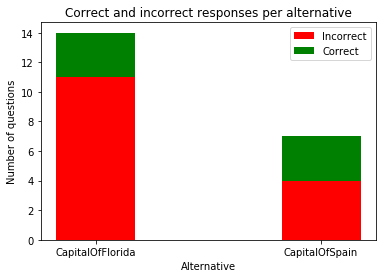

In [130]:
# Bar chart showing the total number of correct and incorrect alternatives 
# selected by players in each multiple-choice question

N = len(alternatives_list)
ind = np.arange(N)

width = 0.35

p1 = plt.bar(ind, false_per_alternative, width, color='r')
p2 = plt.bar(ind, true_per_alternative, width, color='g', bottom=false_per_alternative)
plt.xlabel("Alternative")
plt.ylabel("Number of questions")
plt.xticks(ind, alternatives_list)
plt.legend((p1[0] , p2[0]), ('Incorrect', 'Correct'))
plt.title("Correct and incorrect responses per alternative")
plt.show()

## Alternatives selected per question

In [131]:
# find full list of alternatives
alternatives_list = set()
for player in players_info.keys():
    alternatives_list = alternatives_list.union(set(players_info[player]["alternatives"].keys()))  
alternatives_list = list(alternatives_list)

# responses per alternative
selected_per_alternative = {}
for alt in alternatives_list:
    selected = []
    for player in players_info.keys():
         if alt in players_info[player]["alternatives"].keys():
            alternative, _ = zip(*players_info[player]["alternatives"][alt])
            selected.extend(list(alternative))
    selected_per_alternative[alt] = Counter(selected)

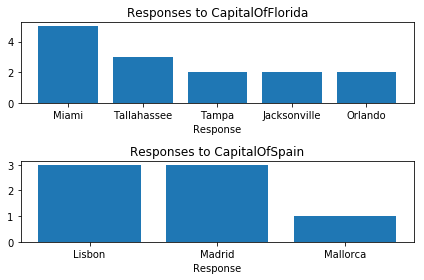

In [132]:
# Multiple bar chart showing the alternatives selected in each multiple-choice question.

number_of_plots = len(selected_per_alternative)
fig, axs = plt.subplots(number_of_plots)
i = 0
for key in selected_per_alternative.keys():
    axs[i].bar(range(len(selected_per_alternative[key])), 
               selected_per_alternative[key].values(), 
               tick_label=list(selected_per_alternative[key].keys()))
    axs[i].set_title('Responses to '+key)
    axs[i].set(xlabel="Response")
    i += 1

plt.tight_layout()